<script async src="https://www.googletagmanager.com/gtag/js?id=UA-59152712-8"></script>
<script>
  window.dataLayer = window.dataLayer || [];
  function gtag(){dataLayer.push(arguments);}
  gtag('js', new Date());

  gtag('config', 'UA-59152712-8');
</script>

# Hermite Interpolator Tutorial in NRPy 

## Author: Maria C. Babiuc-Hamilton
### Template courtesy Zach Etienne and Brandon Clark

### NRPy+ Source Code for this module: [hermite_interpolator.py](../edit/hermite_interpolator.py)


<a id='toc'></a>

# Table of Contents \[Back to [top](#toc)\]
$$\label{toc}$$ 

This notebook is organized as follows

1. [Hermite1D](#hi1d): Cubic Hermite Interpolation on a 1D Uniform Grid
1. [Hermite2D](#hi2d): Bicubic Hermite Interpolation on a 2D Uniform Grid

<!-- 
1. [Step 1](#himodule): The Hermite Interpolator NRPy+ module
    1. [Step 1.a](#hicoeffs_func): The `compute_hicoeffs_histencl()` function
        1. [Step 1.a.i](#exercise): Exercise: Using `compute_hicoeffs_histencl()`
    1. [Step 1.b](#hioutputc): The  `HI_outputC()` function
1. [Step 2](#latex_pdf_output): Output this notebook to $\LaTeX$-formatted PDF  
--> 

<a id='hi1d'></a>

# Hermite Interpolation on a 1D Uniform Grid \[Back to [top](#toc)\]
$$\label{hi1d}$$

In this tutorial we will develop an interpolation technique on uniform grids using the cubic [Hermite interpolation](https://en.wikipedia.org/wiki/Bicubic_interpolation) (HI) techniques and compare it with the Lagrange Intepolator. 

We will develop the cubic Hermite interpolation on a *uniform* numerical grid.
Let's start in one dimension, for proof of principle, and name the coordinate of that dimension $x$.
Since the grid is uniform, the spacing between successive grid points is constant. Let's denote it $h_{x}=x_{k+1} - x_{k}=const$. 
Then, given a function $f(x)$ on this uniform grid, we will adopt the notation

$$
f(x_k) = f_k, ~
\frac{df(x_k)}{dx} = d_x f_k.
$$

We want to interpolate this function onto a point $(x)$ between the two points: $[x_{k}, x_{k+1}]$.

We will need to add $2$ more points, such that, starting from the left to the right, the stencil is: 
$$[x_{k-1}, {\bf x_{k}}, x_{k+1}, x_{k+2}]$$
We define the distance from the known point to the interpolating point: 
$$s(x) = x - x_{k} = \xi h_x$$
where the gid size in $h_x=x_{k+1} - x_{k}$ and $\xi$ is a rational number smaller than unity.

HI techniques are usually constructed as follows:
We fit a third order smooth polynomial to the function, and *impose smoothnes in the derivative* by fitting the derivative of this smooth polynomial to its derivative at the point $x$:
$$
\begin{array}\\
P(x) & = f(x)  = \sum_{i=0}^3 c_{i} s^i \\
\frac{d}{dx}P(x) & = \frac{df(x)}{dx}  = \sum_{i=1}^3 i c_{i} s^{i-1}
\end{array}
$$

The interpolation problem consists of solving this system, to determe the $4$ unknown coefficients:
$$c_{0}, c_{1}, c_{2}, c_{3}.$$

To accomplish this, we form the system of $4$ equations by writing the above equations at the two edges of the interpolation interval:
$$
\begin{array}\\
P(x_{k})             & = f_k   = \sum_{i=0}^3 c_{i} s(x_{k})^i \\
P(x_{k+1})           & = f_{k+1} = \sum_{i=0}^3 c_{i} s(x_{k+1})^i \\
\frac{d}{dx}P(x_{k}) & = d_x f_k = \sum_{i=1}^3 i c_{i} s(x_{k})^{i-1} \\
\frac{d}{dx}P(x_{k+1})& = d_x f_{k+1}= \sum_{i=1}^3 i c_{i} s(x_{k+1})^{i-1}
\end{array}
$$
Noting that: $s(x_{k}) = x_{k} - x_{k} = 0$ and $s(x_{k+1}) = x_{k+1} - x_{k} = h_x$, the system of 4 equations with 4 unknowns simplifies to:
$$ 
\left\{
    \begin{array}\\
f_k         &= c_{0}\\
f_{k+1}     &= c_{0} + c_{1}h + c_{2}h^2 + c_{3}h^3\\
d_x f_k     &= c_{1}\\
d_x f_{k+1} &= c_{1} + 2c_{2}h + 3c_{3}h^2
\end{array}
\right.
$$

The key now is to calculate the numerical derivative at the edges such that the function stays smooth, at least locally.
For this, we introduce a quantity called the *first divided difference* on three out of the $4$ points considered for the interpolation: 
$$
\delta x_{k-1} = \frac{f_{k  }-f_{k-1}}{h_x},~
\delta x_{k  } = \frac{f_{k+1}-f_{k  }}{h_x},~
\delta x_{k+1} = \frac{f_{k+2}-f_{k+1}}{h_x}
$$

Next, we define the *second divided difference* as the average of the reciprocals of the *first divided difference*
$$ \frac{1}{d_k} = {\frac{1}{2\delta_{k-1}}+\frac{1}{2\delta_k}}$$
On the points left and right the interpolating point, these become: 
$$
d_{k  } =\frac{2 \delta_{k  } \delta_{k-1}}{\delta_{k  } + \delta_{k-1}},~
d_{k+1} =\frac{2 \delta_{k+1} \delta_{k  }}{\delta_{k+1} + \delta_{k  }}.
$$

Then we impose the condition of smoothness on the derivative of the function. This condition will be written as: 
$$ 
d_x f_{k} = \left\{
\begin{array}\\
0     & \mbox{if } \ \text{sgn}(\delta_{k−1})\neq \text{sgn}(\delta_{k})\\
dx_{k}& \mbox{if } \ \text{sgn}(\delta_{k−1})=\text{sgn}(\delta_{k})
\end{array}
\right.
$$
and
$$ 
d_x f_{k+1} = \left\{
\begin{array}\\
0        & \mbox{if } \ \text{sgn}(\delta_{k})\neq \text{sgn}(\delta_{k+1})\\
dx_{k+1} & \mbox{if } \ \text{sgn}(\delta_{k})=\text{sgn}(\delta_{k+1}).
\end{array}
\right.
$$

It follows that the derivatives of the functions are replaced with:
$$d_x f_{k} = d_k,~d_x f_{k+1} = d_{k+1}.$$

We also substitute 
$$ 
f_{k+1} = f_k + h_x \delta_k,~
s(x) =\xi h_x
$$
to simplify the stepsize $hx$ from the expressions for the Hermite coefficients. 
Now we form the interpolation polynomial again:
$$
f(x) = P(x) = \sum_{i=0}^3 c_i s^i = \sum_{i=0}^3 C_i \xi^i
$$ 
and
$$
f'(x) = P'(x) = \sum_{i=1}^3 i c_i s^i = \sum_{i=1}^3 i C_i \xi^i
$$ 
where where $c_i h^i = C_i$.
The final form of the 1D Hermite coefficients is:
$$
\begin{array} \\
C_0 &= f_k \\
C_1 &= h_x d_k\\
C_2 &=  h_x(-2 d_k - d_{k+1} + 3 \delta_k)\\
C_3 &= h_x(d_k + d_{k+1} - 2 \delta_k).
\end{array}
$$
**The algorithm is simple: we compute $(f_k, \delta_k, d_k)$ at each point on the grid, impose the continuity condition, and then compute the coefficients $C_i$.** 

Let's solve the system in *python* to find these coefficients.
We use: https://scaron.info/blog/solving-symbolic-equations-with-sympy.html https://problemsolvingwithpython.com/10-Symbolic-Math/10.03-Defining-Variables/
https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.ode.html
There are many ways to solve the system and compute the coefficients. Below we implement an approach that solves directly for $C_i$ imposing also conditions on the derivatives.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import sympy as sym
#from scipy.optimize import fsolve

In [2]:
# define the variables
hx = sym.var('hx')
c0, c1, c2, c3 = sym.var('c0 c1 c2 c3') 
C0, C1, C2, C3 = sym.symbols('C0 C1 C2 C3')
fk, fkp1 = sym.var('fk fkp1') 
delk, dxfk, dxfkp1 = sym.var('delk dxfk dxfkp1') 
fkp1 = fk + hx*delk
c0 = C0
c1 = C1/hx
c2 = C2/(hx**2)
c3 = C3/(hx**3)
#Define the equations
E0 = sym.Eq(c0, fk)
E1 = sym.Eq(c0 + c1*hx + c2*hx**2 + c3*hx**3,fkp1)
E2 = sym.Eq(c1,dxfk)
E3 = sym.Eq(c1 +2* c2*hx + 3*c3*hx**2,dxfkp1)

#Solve
sols=sym.solve([E0, E1, E2, E3], [C0, C1, C2, C3])
C0 = sols[C0].factor()
C1 = sols[C1].factor()
C2 = sols[C2].factor()
C3 = sols[C3].factor()

print ("C0 = ", C0)
print ("C1 = ", C1)
print ("C2 = ", C2)
print ("C3 = ", C3)


print ("c0 = ", (C0/(hx**0)).factor())
print ("c1 = ", (C1/(hx**1)).factor())
print ("c2 = ", (C2/(hx**2)).factor())
print ("c3 = ", (C3/(hx**3)).factor())

C0 =  fk
C1 =  dxfk*hx
C2 =  hx*(3*delk - 2*dxfk - dxfkp1)
C3 =  -hx*(2*delk - dxfk - dxfkp1)
c0 =  fk
c1 =  dxfk
c2 =  (3*delk - 2*dxfk - dxfkp1)/hx
c3 =  -(2*delk - dxfk - dxfkp1)/hx**2


In [3]:
# write the solutions in readable form
print ("\\begin{array} \\\\")
print ("C_0 & = %s\\\\" % sym.latex(C0))
print ("C_1 & = %s\\\\" % sym.latex(C1))
print ("C_2 & = %s\\\\" % sym.latex(C2))
print ("C_3 & = %s"     % sym.latex(C3))
print ("\\end{array}")

\begin{array} \\
C_0 & = fk\\
C_1 & = dxfk hx\\
C_2 & = hx \left(3 delk - 2 dxfk - dxfkp_{1}\right)\\
C_3 & = - hx \left(2 delk - dxfk - dxfkp_{1}\right)
\end{array}


\begin{array} \\
C_0 & = f_k\\
C_1 & = d_x f_k h_x\\
C_2 & = h_x(3 \delta_k - 2 d_x f_k  - d_x f_{k+1})\\
C_3 & = -h_x(2 \delta_k - d_x f_k h_x - d_x f_{k+1})
\end{array}

In [4]:
#another approach, used as sanity check
hx = sym.var('hx')
ci = sym.Matrix([[1,0,0,0],[1,hx,hx**2,hx**3],[0,1,0,0],[0,1, 2*hx,3*hx**2,]])
F = sym.Matrix([fk, fk + hx*delk, dxfk, dxfkp1])
sym.pprint(ci)
sym.pprint(ci.inv()*F)

⎡1  0    0      0  ⎤
⎢                  ⎥
⎢         2      3 ⎥
⎢1  hx  hx     hx  ⎥
⎢                  ⎥
⎢0  1    0      0  ⎥
⎢                  ⎥
⎢                 2⎥
⎣0  1   2⋅hx  3⋅hx ⎦
⎡                    fk                     ⎤
⎢                                           ⎥
⎢                   dxfk                    ⎥
⎢                                           ⎥
⎢  2⋅dxfk   dxfkp₁   3⋅fk   3⋅(delk⋅hx + fk)⎥
⎢- ────── - ────── - ──── + ────────────────⎥
⎢    hx       hx       2            2       ⎥
⎢                    hx           hx        ⎥
⎢                                           ⎥
⎢  dxfk   dxfkp₁   2⋅fk   2⋅(delk⋅hx + fk)  ⎥
⎢  ──── + ────── + ──── - ────────────────  ⎥
⎢    2       2       3            3         ⎥
⎣  hx      hx      hx           hx          ⎦


In [5]:
solM = ci.LUsolve(F)
c0 = sym.pprint(solM[0].factor())
c1 = sym.pprint(solM[1].factor())
c2 = sym.pprint(solM[2].factor())
c3 = sym.pprint(solM[3].factor())

fk
dxfk
3⋅delk - 2⋅dxfk - dxfkp₁
────────────────────────
           hx           
-(2⋅delk - dxfk - dxfkp₁) 
──────────────────────────
             2            
           hx             


Now let's test our interpolator. We will pick the error function (integral of the Gaussian) as the test function which can be manipulated and tuned to increase the sharpness. 
$$
erf(x) = \frac{2}{\sqrt{\pi}}\int_0^x e^{-t^2} dt
$$
It's derivative is: 
$$
\frac{d}{dx}erf(x) = \frac{2}{\sqrt{\pi}}e^{-x^2}
$$

*Note*: The boundary points are just filled with this exact function. For proper boundary, we should impose one-sided smoothness conditions smoothness on the derivatives of the function. 

Text(0, 0.5, '$erf(x)$')

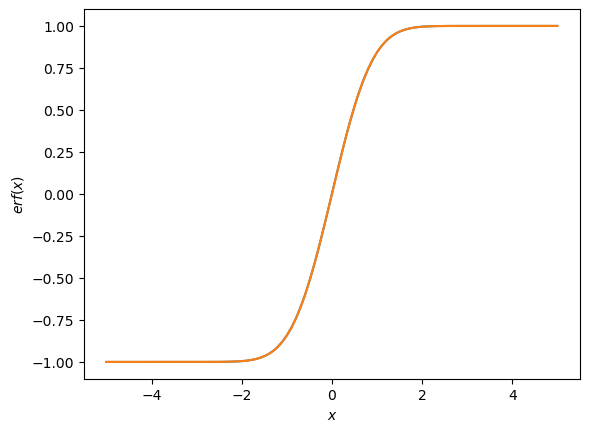

In [6]:
import math as mt

# create a grid of 50 and 100 points, between -5 and 5.  
# check the convergence!
eps = 1e-15 #math.ulp(1.0)
xc = np.linspace(-5.0, 5.0, 101) #coarse grid
xr = np.linspace(-5.0, 5.0, 201) #refined grid

# the refinement
hc = xc[1]-xc[0]
hr = xr[1]-xr[0]

# the desired interpolation location
xi = 1/2

# the position of the interpolation point
xc_xi = xc[:-1] + hc*xi
xr_xi = xr[:-1] + hr*xi

## the exact function
erf = np.vectorize(mt.erf)
derf = np.vectorize(mt.erf)
fc = erf(xc)
fr = erf(xr)
## the exact function on the interpolated points
yc_exact = erf(xc_xi)
yr_exact = erf(xr_xi)

#the derivatives
dfc = np.gradient(fc,xc)
dfr = np.gradient(fr,xr)
dyc_exact = np.gradient(yc_exact,xc_xi)
dyr_exact = np.gradient(yr_exact,xr_xi)

plt.plot(xc, fc)
plt.plot(xr, fr)
plt.xlabel('$x$')
plt.ylabel('$erf(x)$')

In [7]:
# testing the 1D Hermite interpolator

#calculate the smooth derivatives
def smooth_df_1D(hx, fkp2, fkp1, fk, fkm1):
    # first, calculate the first divided difference
    delxkm1 = (fk - fkm1)/(hx)
    delxk   = (fkp1 - fk)/(hx)
    delxkp1  = (fkp2 - fkp1)/(hx)
    # then calculate the slope
    dxk = (2.*delxk*delxkm1)/(delxk + delxkm1)
    dxkp1 = (2.*delxkp1*delxk)/(delxkp1 + delxk)
    # lastly, impose the condition on derivatives
    if np.sign(delxkm1)*np.sign(delxk) == 1:
        dxfk = dxk
    else:
        dxfk = 0
    if np.sign(delxk)*np.sign(delxkp1) == 1:
        dxfkp1 = dxkp1
    else:
        dxfkp1 = 0
    return delxk, dxfk, dxfkp1

#calculate the Hermite c0efficients

def Hermite_1D_coeffs(hx, fk, delxk, dxfk, dxfkp1):
    C0 =  fk
    C1 =  dxfk*hx
    C2 =  hx*(3*delxk - 2*dxfk - dxfkp1)
    C3 = -hx*(2*delxk - dxfk - dxfkp1)
    return C0, C1, C2, C3 

In [8]:
finterpc = []

##call the interpolator on the coarse grid
for i in range(1,len(xc)-2):
    fkp2c = fc[i+2] 
    fkp1c = fc[i+1] 
    fkc = fc[i] 
    fkm1c = fc[i-1]
    #calculate the smoothness condition and the coefficients
    delxkc, dxfkc, dxfkp1c = smooth_df_1D(hc, fkp2c, fkp1c, fkc, fkm1c)
    C0c, C1c, C2c, C3c = Hermite_1D_coeffs(hc, fkc, delxkc, dxfkc, dxfkp1c)
    fintc = C0c + C1c*xi + C2c*xi**2  + C3c*xi**3
    finterpc.append(fintc)

## to plot the interpolated function agains the exact function, we must add the last boundary points
finterpc = np.asarray(finterpc) 
yc_interp = np.concatenate([[yc_exact[0]],finterpc,[yc_exact[len(xc_xi)-1]]])

print(len(yc_interp),len(yc_exact),len(xc_xi))

finterpr = []
dfH = []

##call the interpolator on the refined grid
for i in range(1,len(xr)-2):    
    fkp2r = fr[i+2] 
    fkp1r = fr[i+1] 
    fkr = fr[i] 
    fkm1r = fr[i-1]
    #calculate the smoothness condition and the coefficients
    delxkr, dxfkr, dxfkp1r = smooth_df_1D(hr, fkp2r, fkp1r, fkr, fkm1r)
    C0r, C1r, C2r, C3r = Hermite_1D_coeffs(hr, fkr, delxkr, dxfkr, dxfkp1r)
    fintr = C0r + C1r*xi + C2r*xi**2  + C3r*xi**3
    finterpr.append(fintr)
    dfH.append(dxfkr)

## to plot the interpolated function agains the exact function, we must add the boundary points
#finterpr = np.asarray(finterpr)    
yr_interp = np.concatenate([[yr_exact[0]],finterpr,[yr_exact[len(xr_xi)-1]]])
dfH = np.concatenate([[dyr_exact[0]],dfH,[dyr_exact[len(xr_xi)-1]]])

print(len(yr_interp),len(yr_exact),len(xr_xi))

100 100 100
200 200 200


The error is:
$$
E(h)=\left|f_{num}(h) - f_{exact}(h)\right|= C h^p + H.O.T.
$$
where $C$ is a constant, $h$ is the gridsize, $p$ is the convergence order, and $H.O.T.$ are higher order terms.
The convergence order is the slope of the equation:
$$
\log(E) = \log(C) + p \log(h)
$$
For two resolutions $(h_1, h_2)$, we calculate the convergence order as:
$$
p = \frac{\log\left|E(h_1)/E(h_2)\right|}{\log\left|h_1/h_2\right|}
$$
A symplification assumption is to consider $\log_2$ and $h_1=2 h_2$.
Then the convergence factor will be:
$$
p = \log\left|\frac{E(h_1)}{E(h_2)}\right|
$$

Text(0, 0.5, '$df$')

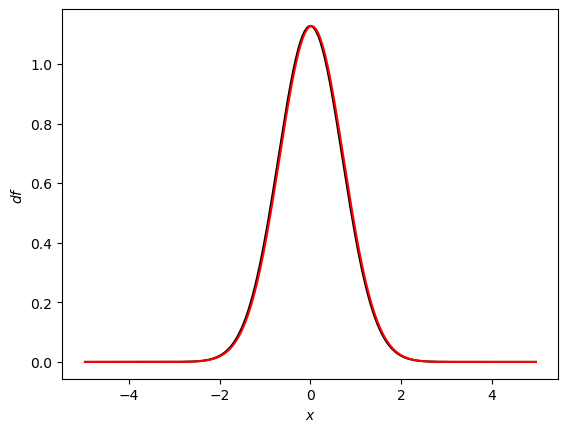

In [9]:
plt.plot(xr_xi, dyr_exact,'k')
plt.plot(xr_xi, dfH,'red')
plt.xlabel('$x$')
plt.ylabel('$df$')

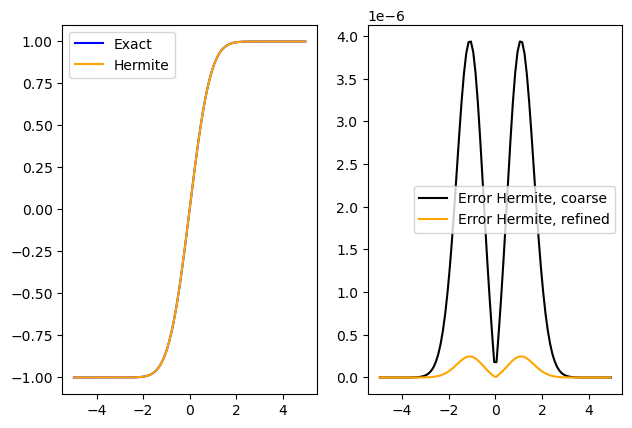

<Figure size 1000x1000 with 0 Axes>

15.935775943350633


In [10]:
# check convergence and plot
import matplotlib.pyplot as plt

fig = plt.figure()
plt.figure(figsize=(10,10))
ax1 = fig.add_subplot(1,2,1)
ax1.xaxis.set_ticks_position('bottom')
ax1.yaxis.set_ticks_position('left')
# plot the coarse functions
ax1.plot(xr_xi,yr_exact, color ='blue', label='Exact')
ax1.plot(xr_xi,yr_interp, color ='orange', label='Hermite')
ax1.legend()

ax2 = fig.add_subplot(1,2,2)
ax2.xaxis.set_ticks_position('bottom')
ax2.yaxis.set_ticks_position('left')
# plot the refined functions
ax2.plot(xc_xi,abs(yc_interp-yc_exact), color ='black', label='Error Hermite, coarse')
ax2.plot(xr_xi[::2],abs(yr_interp[::2]-yr_exact[::2]), color ='orange', label='Error Hermite, refined')
ax2.legend()

#fig.tight_layout()
fig.subplots_adjust(left=None, bottom=None, right=1, top=None, wspace=None, hspace=None)
plt.show()

print(max(yc_interp-yc_exact)/max(yr_interp-yr_exact))

The coarse and refined arrays are not equal. 
When calculating the error, we can choose to either undersample the refined array, or to calculate the error norm, and extract the $\log_2$.

pLinf= 3.9941973626401914
pL2= 3.4975703323303096
pRMS= 3.997570332330309


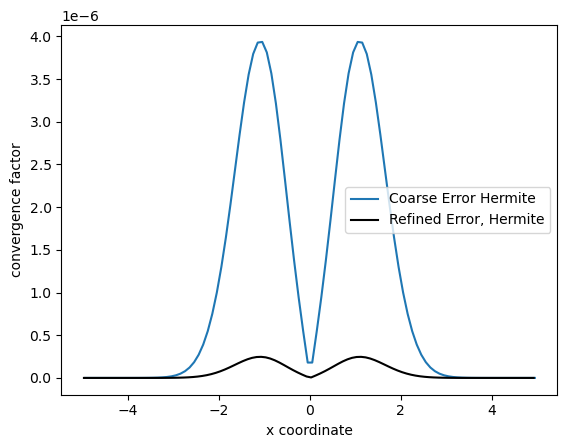

3.99479252685175


In [11]:
# undersample? Note that we will not obtain the function at the same points!

# calculate the L2 and Linf for coarse and refined grids
from numpy.linalg import norm 
import math
# the error
Ec = (yc_exact-yc_interp)
Er = (yr_exact-yr_interp)
# the infinity norm
Linfc = norm(Ec,np.inf)
Linfr = norm(Er,np.inf)
print("pLinf=", math.log2(Linfc/Linfr)) 

#the L2 norm
L2c = norm(Ec,2)
L2r = norm(Er,2)
print("pL2=", math.log2(L2c/L2r))

#The root mean square error
Nc = np.size(yc_interp)
Nr = np.size(yr_interp)
RMSc = np.sqrt(np.sum(np.power((Ec),2))/Nc)
RMSr = np.sqrt(np.sum(np.power((Er),2))/Nr)
print("pRMS=", math.log2(RMSc/RMSr))

# now undersample the refined error and calculate the convergence factor:
cEr = Er[::2]

plt.plot(xc_xi, abs(Ec), linewidth=1.5, label='Coarse Error Hermite')
plt.legend()
plt.plot(xr_xi[::2], abs(cEr), linewidth=1.5, color='black', label='Refined Error, Hermite')
plt.legend()
plt.xlabel('x coordinate')
plt.ylabel('convergence factor')
#plt.yscale('log')
plt.show()

max_Ec = Ec.max()
max_cEr = cEr.max()
print(math.log2(max_Ec/max_cEr))

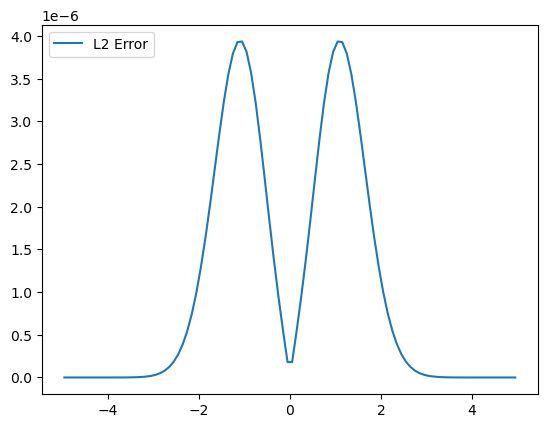

1.0552179810064537e-06


In [12]:
# plot the error
diff = np.subtract(yc_exact,yc_interp)
square = np.square(diff)

l2err = np.sqrt(square)
plt.plot(xc_xi,l2err, label='L2 Error')

plt.legend(loc='upper left')
#plt.yscale('log')
# show the plot
plt.show()

print(l2err.mean())

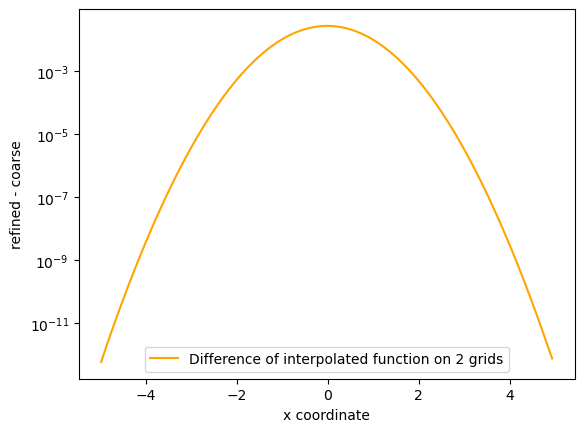

In [13]:
plt.plot(xr_xi[::2],abs(yr_interp[::2]-yc_interp), color ='orange', label='Difference of interpolated function on 2 grids')
plt.legend()
plt.xlabel('x coordinate')
plt.ylabel('refined - coarse')
plt.yscale('log')
plt.show()

/var/folders/z_/8qxrc1dd5pb7vpgvv8k13j5h0000gn/T/ipykernel_9371/2422863694.py:5: RuntimeWarning: invalid value encountered in divide
  p = np.nan_to_num(abs(Ec) / abs(cEr))


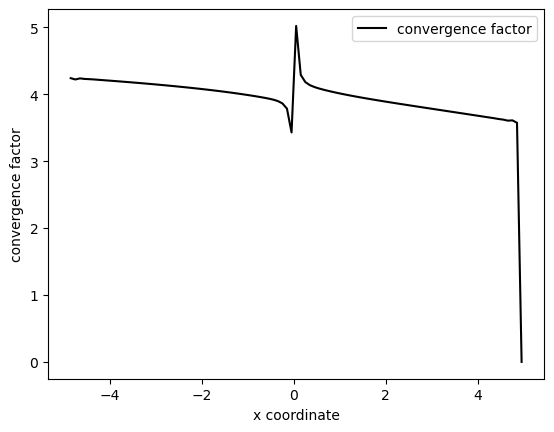

In [14]:
pc = abs(Ec)/hc 
log2Ec = np.log2(abs(Ec),where=Ec>0)
cpr = abs(cEr)/hr 
log2cEr =np.log2(abs(cEr),where=cEr>0)
p = np.nan_to_num(abs(Ec) / abs(cEr))
max_pc = pc.max()
max_cpr = cpr.max()

#plt.plot(xc_xi, p, linewidth=1.5, label='Coarse convergence factor')
#plt.legend()
plt.plot(xc_xi, np.log2(p,where=p>0), linewidth=1.5, color='black', label='convergence factor')
plt.legend()
plt.xlabel('x coordinate')
plt.ylabel('convergence factor')
#plt.yscale('log')
plt.show()

Below we implement a Lagrange interpolator, for check.
We have 4 points, so the Lagrange polynomial will be of degree 3.
The basic $3^{rd}$ order interpolator will be:
$$P(x) = \sum_{j=k-1}^{k+2} f(x_j) L_{j}(x)$$
where:
$$L_{k-1}(x) = \frac{(x - x_k)(x - x_{k+1})(x - x_{k+2})}
{(x_{k-1} - x_k)(x_{k-1} - x_{k+1})(x_{k-1} - x_{k+2})}$$
$$L_{k}(x) = \frac{(x - x_{k-1})(x - x_{k+1})(x_k - x_{k+2})}
{(x_{k} - x_{k-1})(x_{k} - x_{k+1})(x_{k} - x_{k+2})}$$
$$L_{k+1}(x) = \frac{(x - x_{k-1})(x - x_{k})(x - x_{k+2})}
{(x_{k+1} - x_{k-1})(x_{k+1} - x_{k})(x_{k+1} - x_{k+2})}$$
$$L_{k+2}(x) = \frac{(x - x_{k-1})(x - x_{k})(x - x_{k+1})}
{(x_{k+2} - x_{k-1})(x_{k+2} - x_{k})(x_{k+2} - x_{k+1})}$$
Noting that: $x = x_k + \xi h_x$, $x_{k-1} = x_k - h_x$, $x_{k+1} = x_k + h_x$ and $x_{k+2} = x_{k+1} + h_x$, we have:
$$L_{k-1}(\xi) = -\frac{\xi}{3} + \frac{\xi^2}{2} - \frac{\xi^3}{6}$$
$$L_{k}(\xi) =1 -\frac{\xi}{2} - \xi^2 + \frac{\xi^3}{2}$$
$$L_{k+1}(\xi) = \xi + \frac{\xi^2}{2} - \frac{\xi^3}{2}$$
$$L_{k+2}(\xi) = -\frac{\xi}{6} + \frac{\xi^3}{6}$$
We implement it below.
Note that we can easily take the derivative of the interpolator, as:
$$P'(x) = \sum_{j=k-1}^{k+2} f(x_j) L_{j}'(x)$$
where:
$$L_{k-1}'(\xi) = -\frac{1}{3 h_x} + \frac{\xi}{h_x} - \frac{\xi^2}{2 h_x}$$
$$L_{k}'(\xi) =-\frac{1}{2 h_x} - \frac{2 \xi}{h_x} + \frac{3 \xi^2}{2 h_x}$$
$$L_{k+1}'(\xi) = \frac{1}{h_x} + \frac{\xi}{h_x} - \frac{3 \xi^2}{2 h_x}$$
$$L_{k+2}'(\xi) = -\frac{1}{6 h_x} + \frac{\xi^2}{2 h_x}$$

100 100 100
200 200 200


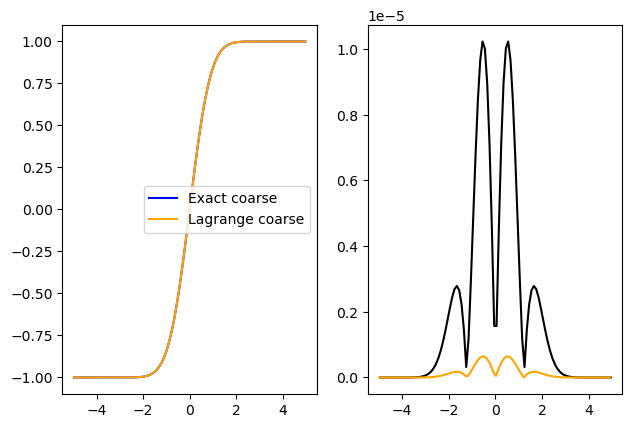

<Figure size 1000x1000 with 0 Axes>

15.882669752577744


In [15]:
#calculate the Lagrange Polynomial

def Lagrange3_1D(xi,fkm1, fk, fkp1, fkp2):
    Lkm1 =    -(xi)/3. + (xi*xi)/2. - (xi*xi*xi)/6.
    Lk   = 1. -(xi)/2. - (xi*xi)/1. + (xi*xi*xi)/2.
    Lkp1 =    +(xi)/1. + (xi*xi)/2. - (xi*xi*xi)/2.
    Lkp2 =    -(xi)/6.              + (xi*xi*xi)/6.
    PL3 = fkm1*Lkm1 + fk*Lk + fkp1*Lkp1 + fkp2*Lkp2
    return PL3 

##call the Lagrange interpolator on the coarse grid
fLinterpc = []
for i in range(1,len(xc)-2):
    fkm1c = fc[i-1]
    fkc   = fc[i] 
    fkp1c = fc[i+1]
    fkp2c = fc[i+2] 
    fLintc = Lagrange3_1D(xi,fkm1c,fkc,fkp1c,fkp2c)
    fLinterpc.append(fLintc)

## to plot the interpolated function agains the exact function, we must add the last boundary points
fLinterpc = np.asarray(fLinterpc) 
yc_Linterp = np.concatenate([[yc_exact[0]],fLinterpc,[yc_exact[len(xc_xi)-1]]])

print(len(yc_Linterp),len(yc_exact),len(xc_xi))

##call the Lagrange interpolator on the refined grid
fLinterpr = []
for i in range(1,len(xr)-2):    
    fkm1r = fr[i-1]
    fkr   = fr[i] 
    fkp1r = fr[i+1]
    fkp2r = fr[i+2] 
    fLintr = Lagrange3_1D(xi,fkm1r,fkr,fkp1r,fkp2r)
    fLinterpr.append(fLintr)

## to plot the interpolated function agains the exact function, we must add the boundary points
fLinterpr = np.asarray(fLinterpr)    
yr_Linterp = np.concatenate([[yr_exact[0]],fLinterpr,[yr_exact[len(xr_xi)-1]]])

print(len(yr_Linterp),len(yr_exact),len(xr_xi))

fig = plt.figure()
plt.figure(figsize=(10,10))
ax1 = fig.add_subplot(1,2,1)
ax1.xaxis.set_ticks_position('bottom')
ax1.yaxis.set_ticks_position('left')
# plot the coarse functions
ax1.plot(xr_xi,yr_exact, color ='blue', label='Exact coarse')
ax1.plot(xr_xi,yr_Linterp, color ='orange', label='Lagrange coarse')
ax1.legend()

ax2 = fig.add_subplot(1,2,2)
ax2.xaxis.set_ticks_position('bottom')
ax2.yaxis.set_ticks_position('left')
# plot the refined functions
ax2.plot(xc_xi,abs(yc_Linterp-yc_exact), color ='black', label='Error Lagrange, coarse')
ax2.plot(xr_xi[::2],abs(yr_Linterp[::2]-yr_exact[::2]), color ='orange', label='Error Lagrange, refined')
#fig.tight_layout()
fig.subplots_adjust(left=None, bottom=None, right=1, top=None, wspace=None, hspace=None)
plt.show()

print(max(yc_Linterp-yc_exact)/max(yr_Linterp-yr_exact))

3.989381534189552


/var/folders/z_/8qxrc1dd5pb7vpgvv8k13j5h0000gn/T/ipykernel_9371/2802958650.py:13: RuntimeWarning: invalid value encountered in divide
  pL = np.nan_to_num(abs(EcL) / abs(cErL))


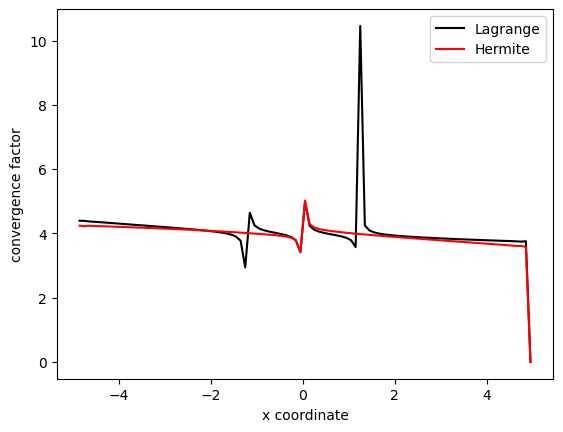

In [16]:
# plot the error
diffL = np.subtract(yc_exact,yc_Linterp)
squareL = np.square(diff)

EcL = (yc_exact-yc_Linterp)
ErL = (yr_exact-yr_Linterp)
cErL = ErL[::2]

pcL = abs(EcL)/hc 
log2EcL = np.log2(abs(EcL),where=EcL>0)
cprL = abs(cEr)/hr 
log2cErL =np.log2(abs(cErL),where=cErL>0)
pL = np.nan_to_num(abs(EcL) / abs(cErL))
max_pcL = pcL.max()
max_cprL = cprL.max()

max_EcL = EcL.max()
max_cErL = cErL.max()
print(math.log2(max_EcL/max_cErL))

#plt.plot(xc_xi, p, linewidth=1.5, label='Coarse convergence factor')
#plt.legend()
plt.plot(xc_xi, np.log2(pL,where=pL>0) , linewidth=1.5, color='black', label='Lagrange')
plt.plot(xc_xi, np.log2(p,where=p>0), linewidth=1.5, color='red', label='Hermite')
plt.legend()
plt.xlabel('x coordinate')
plt.ylabel('convergence factor')
#plt.yscale('log')
plt.show()

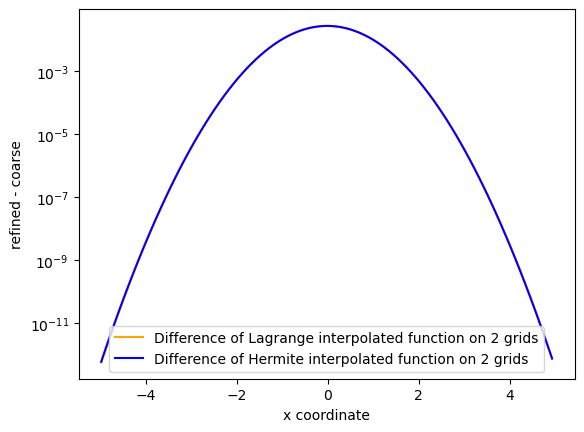

In [17]:
plt.plot(xr_xi[::2],abs(yr_Linterp[::2]-yc_Linterp), color ='orange', label='Difference of Lagrange interpolated function on 2 grids')
plt.plot(xr_xi[::2],abs(yr_interp[::2]-yc_interp), color ='blue', label='Difference of Hermite interpolated function on 2 grids')
plt.legend()
plt.xlabel('x coordinate')
plt.ylabel('refined - coarse')
plt.yscale('log')
plt.show()

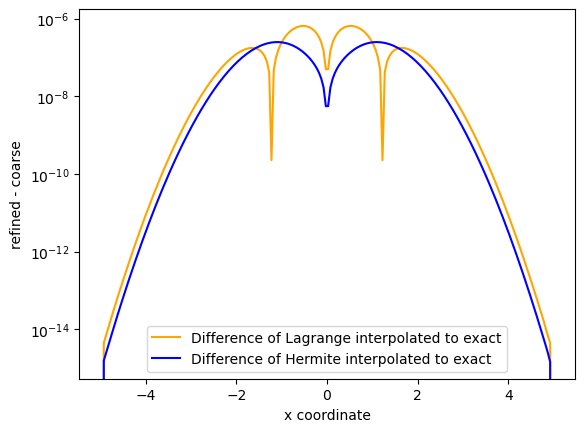

In [18]:
plt.plot(xr_xi,abs(yr_exact-yr_Linterp), color ='orange', label='Difference of Lagrange interpolated to exact')
plt.plot(xr_xi,abs(yr_exact-yr_interp), color ='blue', label='Difference of Hermite interpolated to exact')
plt.legend()
plt.xlabel('x coordinate')
plt.ylabel('refined - coarse')
plt.yscale('log')
plt.show()

In conclusion, the Lagrange interpolator seems to be performing better than the Hermite interpolator for functions with less inflection points or extrema, and it's performance appraches the one of the Hermite interpolator as the number of inflexion points increases.

The generalization of the Lagrange interpolator to 2D is straightforward:
$$P(x,y) = \sum_{i=k-1}^{k+2}\sum_{j=k-1}^{k+2} f(x_i, y_j) L_{ij}(\xi,\mu)$$
where:
$L_{ij}(\xi,\mu) = L_{i}(\xi) L_{j}(\mu)$ with the respective 1D Lagrange coefficients $L_{i}(\xi) L_{j}(\mu)$.

<a id='hi2d'></a>

# Hermite Interpolation on a 2D Uniform Grid \[Back to [top](#toc)\]
$$\label{hi2d}$$

A *bicubic* Hermite interpolation extends the 1D cubic interpolation to a 2D grid. 

We consider a stencil of $4\times 4=16$ known points, on a uniform 2D grid, starting from the lower left corner us, and then advancing right: 


$$
[(x_{k-1},y_{k-1}), (x_{k-1},y_{k}), (x_{k-1},y_{k+1}), (x_{k-1},y_{k+2}), \\
 (x_{k  },y_{k-1}), ({\bf x_{k  },y_{k}}), (x_{k  },y_{k+1}), (x_{k  },y_{k+2}), \\
 (x_{k+1},y_{k-1}), (x_{k+1},y_{k}), (x_{k+1},y_{k+1}), (x_{k+1},y_{k+2}), \\
 (x_{k+1},y_{k-1}), (x_{k+2},y_{k}), (x_{k+2},y_{k+1}), (x_{k+2},y_{k+1}]) .
$$

We interpolate onto the 2D point $(x,y)$ in the middle of the rectangle formed by the $4$ corners starting lower-left and going counterclockwise: 
$$
[x_{k  },y_{k  }, x_{k  },y_{k+1},\\
 x_{k+1},y_{k+1}, x_{k+1},y_{k  }].
 $$

The Hermite interpolator is:
$$P(x,y) = \sum_{i=0}^3 \sum_{j=0}^3 c_{ij} s_x^i s_y^j,$$
where $s_x$ is the distance in the $x$ direction from the point of interpolation $(x,y)$ to $x_k$, namely: 
$$s_x(x) = x - x_k = \xi h_x  $$
and $s_y$ is the distance in the $y$ direction from point of interpolation $(x,y)$ to $y_k$: 
$$s_y(y) = y - y_k = \mu h_y.$$

We now form the system of $16$ equations with 16 unknowns. We have $4$ equations for the corners:
$$
\begin{array} \\
P(x_{k  },y_{k  }) &= f_{k  ,k  } = \sum_{i=0}^3 \sum_{j=0}^3 c_{ij} s_x(x_{k  })^i s_y(y_{k  })^j,\\
P(x_{k  },y_{k+1}) &= f_{k  ,k+1} = \sum_{i=0}^3 \sum_{j=0}^3 c_{ij} s_x(x_{k  })^i s_y(y_{k+1})^j\\
P(x_{k+1},y_{k+1}) &= f_{k+1,k+1} = \sum_{i=0}^3 \sum_{j=0}^3 c_{ij} s_x(x_{k+1})^i s_y(y_{k+1})^j\\
P(x_{k+1},y_{k  }) &= f_{k+1,k  } = \sum_{i=0}^3 \sum_{j=0}^3 c_{ij} s_x(x_{k+1})^i s_y(y_{k  })^j
\end{array}
$$

Next we have $4$ equations for the $x$ derivative at the $4$ corners:
$$
\begin{array} \\
\frac{d}{dx}P(x_{k  },y_{k  }) & = d_x f_{k  ,k  } = \sum_{i=1}^3 \sum_{j=0}^3 i c_{ij} 
s_x(x_{k  })^{i-1} s_y(y_{k  })^j\\
\frac{d}{dx}P(x_{k  },y_{k+1}) & = d_x f_{k  ,k+1} = \sum_{i=1}^3 \sum_{j=0}^3 i c_{ij} 
s_x(x_{k  })^{i-1} s_y(y_{k+1})^j\\
\frac{d}{dx}P(x_{k+1},y_{k+1}) & = d_x f_{k+1,k+1} = \sum_{i=1}^3 \sum_{j=0}^3 i c_{ij} 
s_x(x_{k+1})^{i-1} s_y(y_{k+1})^j\\
\frac{d}{dx}P(x_{k+1},y_{k  }) & = d_x f_{k+1,k  } = \sum_{i=1}^3 \sum_{j=0}^3 i c_{ij} 
s_x(x_{k+1})^{i-1} s_y(y_{k  })^j
\end{array}
$$

We are adding now $4$ equations for the $y$ derivative at the $4$ corners:
$$
\begin{array} \\
\frac{d}{dy}P(x_{k  },y_{k  }) & = d_y f_{k  ,k  } = \sum_{i=0}^3 \sum_{j=1}^3 j c_{ij} 
s_x(x_{k  })^{i} s_y(y_{k  })^{j-1} \\
\frac{d}{dy}P(x_{k  },y_{k+1}) & = d_y f_{k  ,k+1} = \sum_{i=0}^3 \sum_{j=1}^3 j c_{ij} 
s_x(x_{k  })^{i} s_y(y_{k+1})^{j-1} \\
\frac{d}{dy}P(x_{k+1},y_{k+1}) & = d_y f_{k+1,k+1} = \sum_{i=0}^3 \sum_{j=1}^3 j c_{ij} 
s_x(x_{k+1})^{i} s_y(y_{k+1})^{j-1} \\
\frac{d}{dy}P(x_{k+1},y_{k  }) & = d_y f_{k+1,k  } = \sum_{i=0}^3 \sum_{j=1}^3 j c_{ij} 
s_x(x_{k+1})^{i} s_y(y_{k  })^{j-1}
\end{array}
$$

Up to now we have $12$ equations. The last $4$ equations are obtained by adding to this the mixed derivatives: 
$\frac{d^2}{dxdy}P(x,y) = f_{xy} = \sum_{i=1}^3 \sum_{j=1}^3 ij c_{ij} s_x^{i-1} s_y^{j-1}$, which becomes at the $4$ corners:

$$
\begin{array} \\
\frac{d^2}{dxdy}P(x_{k  },y_{k  }) & = d_{xy} f_{k  ,k  } = \sum_{i=1}^3 \sum_{j=1}^3 ij c_{ij} 
s_x(x_{k  })^{i-1} s_y(y_{k  })^{j-1}\\
\frac{d^2}{dxdy}P(x_{k  },y_{k+1}) & = d_{xy} f_{k  ,k+1} = \sum_{i=1}^3 \sum_{j=1}^3 ij c_{ij} 
s_x(x_{k  })^{i-1} s_y(y_{k+1})^{j-1}\\
\frac{d^2}{dxdy}P(x_{k+1},y_{k+1}) & = d_{xy} f_{k+1,k+1} = \sum_{i=1}^3 \sum_{j=1}^3 ij c_{ij} 
s_x(x_{k+1})^{i-1} s_y(y_{k+1})^{j-1}\\
\frac{d^2}{dxdy}P(x_{k+1},y_{k  }) & = d_{xy} f_{k+1,k  } = \sum_{i=1}^3 \sum_{j=1}^3 ij c_{ij} 
s_x(x_{k+1})^{i-1} s_y(y_{k  })^{j-1}
\end{array}
$$

Let's solve this system of $16$ equations for the $16$ unknown Hermite 2D coefficients by implementing it in Python.

In [19]:
import sympy as sym
# define the variables
hx, hy = sym.var('hx, hy')
x, y, xk, yk = sym.var('x, y, xk, yk')
c00, c01, c02, c03 = sym.var('c00 c01 c02 c03') 
c10, c11, c12, c13 = sym.var('c10 c11 c12 c13') 
c20, c21, c22, c23 = sym.var('c20 c21 c22 c23') 
c30, c31, c32, c33 = sym.var('c30 c31 c32 c33') 

fkk, fkkp1, fkp1kp1, fkp1k         = sym.symbols('fkk fkkp1 fkp1kp1 fkp1k')
dxfkk, dxfkkp1, dxfkp1kp1, dxfkp1k = sym.symbols('dxfkk dxfkkp1 dxfkp1kp1 dxfkp1k')
dyfkk, dyfkkp1, dyfkp1kp1, dyfkp1k = sym.symbols('dyfkk dyfkkp1 dyfkp1kp1 dyfkp1k')
dxyfkk, dxyfkkp1, dxyfkp1kp1, dxyfkp1k = sym.symbols('dxyfkk dxyfkkp1 dxyfkp1kp1 dxyfkp1k')

In [20]:
# introduce the derivatives
delxkk, delykk, delykp1k = sym.symbols('delxkk delykk delykp1k') 

fkp1k = fkk + hx*delxkk
fkkp1 = fkk + hy*delykk
fkp1kp1 = fkk + hx*delxkk + hy*delykp1k

In [21]:
# define the sums that enter in the equations to be solved
sx = x - xk
sy = y - yk
i, j = sym.var('i j')
cij = sym.Matrix([[c00, c01, c02, c03],[c10, c11, c12, c13],
                  [c20, c21, c22, c23],[c30, c31, c32, c33]])
#sym.pprint(cij)

Sum11 = sym.summation(cij[i, j]*sx.subs(x,xk)**i*sy.subs(y,yk)**j, (j, 0, 3), (i, 0, 3))
Sum12 = sym.summation(cij[i, j]*sx.subs(x,xk)**i*sy.subs(y,yk+hy)**j, (j, 0, 3), (i, 0, 3)) 
Sum22 = sym.summation(cij[i, j]*sx.subs(x,xk+hx)**i*sy.subs(y,yk+hy)**j, (j, 0, 3), (i, 0, 3))
Sum21 = sym.summation(cij[i, j]*sx.subs(x,xk+hx)**i*sy.subs(y,yk)**j, (j, 0, 3), (i, 0, 3)) 

Sumx11 = sym.summation((i+1)*cij[i+1, j]*sx.subs(x,xk)**i*sy.subs(y,yk)**j, (j, 0, 3), (i, 0, 2))
Sumx12 = sym.summation((i+1)*cij[i+1, j]*sx.subs(x,xk)**i*sy.subs(y,yk+hy)**j, (j, 0, 3), (i, 0, 2)) 
Sumx22 = sym.summation((i+1)*cij[i+1, j]*sx.subs(x,xk+hx)**i*sy.subs(y,yk+hy)**j, (j, 0, 3), (i, 0, 2)) 
Sumx21 = sym.summation((i+1)*cij[i+1, j]*sx.subs(x,xk+hx)**i*sy.subs(y,yk)**j, (j, 0, 3), (i, 0, 2))

Sumy11 = sym.summation((j+1)*cij[i, j+1]*sx.subs(x,xk)**i*sy.subs(y,yk)**j, (j, 0, 2), (i, 0, 3))
Sumy12 = sym.summation((j+1)*cij[i, j+1]*sx.subs(x,xk)**i*sy.subs(y,yk+hy)**j, (j, 0, 2), (i, 0, 3))
Sumy22 = sym.summation((j+1)*cij[i, j+1]*sx.subs(x,xk+hx)**i*sy.subs(y,yk+hy)**j, (j, 0, 2), (i, 0, 3))
Sumy21 = sym.summation((j+1)*cij[i, j+1]*sx.subs(x,xk+hx)**i*sy.subs(y,yk)**j, (j, 0, 2), (i, 0, 3))

Sumxy11 = sym.summation((i+1)*(j+1)*cij[i+1, j+1]*sx.subs(x,xk)**i*sy.subs(y,yk)**j, (j, 0, 2), (i, 0, 2))
Sumxy12 = sym.summation((i+1)*(j+1)*cij[i+1, j+1]*sx.subs(x,xk)**i*sy.subs(y,yk+hy)**j, (j, 0, 2), (i, 0, 2))
Sumxy22 = sym.summation((i+1)*(j+1)*cij[i+1, j+1]*sx.subs(x,xk+hx)**i*sy.subs(y,yk+hy)**j, (j, 0, 2), (i, 0, 2))
Sumxy21 = sym.summation((i+1)*(j+1)*cij[i+1, j+1]*sx.subs(x,xk+hx)**i*sy.subs(y,yk)**j, (j, 0, 2), (i, 0, 2))

#print ("Sum33 = ", Sum33)

In [22]:
#Define the equations
E11 = sym.Eq(Sum11.factor(),fkk)
E12 = sym.Eq(Sum12.factor(),fkkp1)
E22 = sym.Eq(Sum22.factor(),fkp1kp1)
E21 = sym.Eq(Sum21.factor(),fkp1k)

Ex11 = sym.Eq(Sumx11.factor(),dxfkk)
Ex12 = sym.Eq(Sumx12.factor(),dxfkkp1)
Ex22 = sym.Eq(Sumx22.factor(),dxfkp1kp1)
Ex21 = sym.Eq(Sumx21.factor(),dxfkp1k)

Ey11 = sym.Eq(Sumy11.factor(),dyfkk)
Ey12 = sym.Eq(Sumy12.factor(),dyfkkp1)
Ey22 = sym.Eq(Sumy22.factor(),dyfkp1kp1)
Ey21 = sym.Eq(Sumy21.factor(),dyfkp1k)

Exy11 = sym.Eq(Sumxy11.factor(),dxyfkk)
Exy12 = sym.Eq(Sumxy12.factor(),dxyfkkp1)
Exy22 = sym.Eq(Sumxy22.factor(),dxyfkp1kp1)
Exy21 = sym.Eq(Sumxy21.factor(),dxyfkp1k)

#solve the system
sols2D = sym.solve([E11,E12,E22,E21, Ex11,Ex12,Ex22,Ex21, 
                    Ey11,Ey12,Ey22,Ey21, Exy11,Exy12,Exy22,Exy21], 
                   [c00,c01,c02,c03, c10,c11,c12,c13, c20,c21,c22,c23, c30,c31,c32,c33])

cijsols = sym.Matrix([[sols2D[c00].factor(), sols2D[c01].factor(), sols2D[c02].factor(), sols2D[c03].factor()],
                      [sols2D[c10].factor(), sols2D[c11].factor(), sols2D[c12].factor(), sols2D[c13].factor()],
                      [sols2D[c20].factor(), sols2D[c21].factor(), sols2D[c22].factor(), sols2D[c23].factor()],
                      [sols2D[c30].factor(), sols2D[c31].factor(), sols2D[c32].factor(), sols2D[c33].factor()]])
Cijsols = sym.Matrix([[cijsols[0,0],         cijsols[0,1]*(hy),         cijsols[0,2]*(hy**2),         cijsols[0,3]*(hy**3)],
                      [cijsols[1,0]*(hx),    cijsols[1,1]*(hx)*(hy),    cijsols[1,2]*(hx)*(hy**2),    cijsols[1,3]*(hx)*(hy**3)],
                      [cijsols[2,0]*(hx**2), cijsols[2,1]*(hx**2)*(hy), cijsols[2,2]*(hx**2)*(hy**2), cijsols[2,3]*(hx**2)*(hy**3)],
                      [cijsols[3,0]*(hx**3), cijsols[3,1]*(hx**3)*(hy), cijsols[3,2]*(hx**3)*(hy**2), cijsols[3,3]*(hx**3)*(hy**3)]])

In [23]:
#sanity check
print("c20 = ",cijsols[2,0])
print("C20 = ",Cijsols[2,0])
print("C2 = ",C2)

c20 =  (3*delxkk - 2*dxfkk - dxfkp1k)/hx
C20 =  hx*(3*delxkk - 2*dxfkk - dxfkp1k)
C2 =  hx*(3*delk - 2*dxfk - dxfkp1)


*Note*
Will it be possible to impose smoothness conditions on the $2^{nd}$ derivative?
or a smooth function of two variables $f (x, y)$, the matching condition for mixed derivatives must be fulfilled:
$$
\frac{d^2}{dxdy}f(x,y) = \frac{d^2}{dydx}f(x,y)
$$
It looks like a $3^{rd}$ order Hermite interpolator will not allow us to put the smoothness condition on the $2^{nd}$ derivative as well. For this, we will need a $5^{th}$ order Hermite interpolator.

We test with the 2D error function. Let's start by creating the $2D$ grid and using the exact function:
$erf2D\rightarrow erf(\sqrt{x^2+y^2})$ and $erf2D\rightarrow erf(x) erf(y)$. Observe that $erf2D\rightarrow erf(x) erf(y)$ is better, that's what will use.

In [24]:
def erfr(x, y):
    r = np.sqrt(np.power(x,2) + np.power(y,2))
    return erf(r)

def erfxy(x, y):
    return (erf(x)*erf(y))

In [25]:
import math as mt
# create a 2D grid of 50 and 100 points, between -5 and 5.  

xvc = np.linspace(-5.0, 5.0, 101) #coarse grid
yvc = np.linspace(-5.0, 5.0, 101) #coarse grid
[xc, yc] = np.meshgrid(xvc, yvc)
#plt.plot(xc, yc, marker='.', color='k', linestyle='none')

xvc = np.linspace(-5.0, 5.0, 101) #coarse grid
yvc = np.linspace(-5.0, 5.0, 101) #coarse grid
[xc, yc] = np.meshgrid(xvc, yvc)
#plt.plot(xc, yc, marker='.', color='k', linestyle='none')

In [26]:
#plt.contourf(xc,yc,(erf2D(xc,yc)),50)

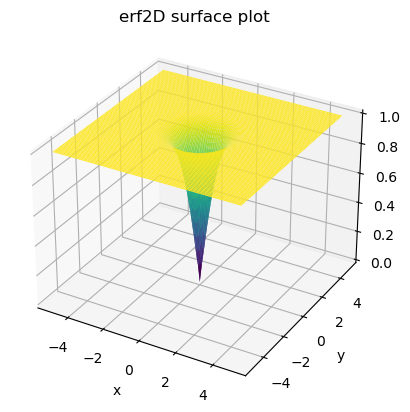

In [28]:
from mpl_toolkits import mplot3d
from matplotlib import cm
fig = plt.figure()
ax = plt.axes(projection='3d')
#ax.contour3D(xc,yc,erf2D(xc,yc),100)
ax.plot_surface(xc,yc,(erfr(xc,yc)),rstride=1, cstride=1, cmap='viridis')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.set_title('erf2D surface plot');

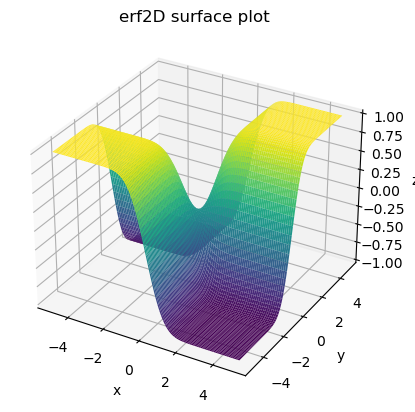

In [29]:
from mpl_toolkits import mplot3d
from matplotlib import cm
fig = plt.figure()
ax = plt.axes(projection='3d')
#ax.contour3D(xc,yc,erf2D(xc,yc),100)
ax.plot_surface(xc,yc,erfxy(xc,yc),rstride=1, cstride=1, cmap='viridis')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.set_title('erf2D surface plot');

In [ ]:
#    # then calculate the slope
#    dxk = (2.*delxk*delxkm1)/(delxk + delxkm1)
#    dxkp1 = (2.*delxkp1*delxk)/(delxkp1 + delxk)
#    # lastly, impose the condition on derivatives
#    if np.sign(delxkm1) == np.sign(delxk):
#        dxfk = dxk
#    else:
#        dxfk = 0
#    if np.sign(delxk) == np.sign(delxkp1):
#        dxfkp1 = dxkp1
#    else:
#        dxfkp1 = 0
#    return delxk, dxfk, dxfkp1

#calculate the smooth derivatives
def smooth_df_2D(hx, hy, 
                fkp2kp2, fkp1kp2, fkkp2, fkm1kp2,
                fkp2kp1, fkp1kp1, fkkp1, fkm1kp1,
                fkp2k  , fkp1k  , fkk  , fkm1k  ,
                fkp2km1, fkp1km1, fkkm1, fkm1km1):
    # first, calculate the first divided difference    
    delxkm1k = (fkk - fkm1k)/(hx)
    delxkk   = (fkp1k - fkk)/(hx)
    delxkp1k = (fkp2k - fkp1k)/(hx)
    
    delxkm1kp1 = (fkkp1 - fkm1kp1)/(hx)
    delxkkp1   = (fkp1kp1 - fkkp1)/(hx)
    delxkp1kp1 = (fkp2kp1 - fkp1kp1)/(hx)
    
    delykkm1 = (fkk - fkkm1)/(hy)
    delykk   = (fkkp1 - fkk)/(hy)
    delykkp1 = (fkkp2 - fkkp1)/(hy)
    
    delykp1km1 = (fkp1k - fkp1km1)/(hy)
    delykp1k   = (fkp1kp1 - fkp1k)/(hy)
    delykp1kp1 = (fkp1kp2 - fkp1kp1)/(hy)
    
    # then calculate the slopes
    dxkk  = (2.*delxkk*delxkm1k)/(delxkk + delxkm1k)
    dxkkp1 = (2.*delxkkp1*delxkm1kp1)/(delxkkp1 + delxkm1kp1)
    dxkp1kp1 = (2.*delxkp1kp1*delxkkp1)/(delxkp1kp1 + delxkkp1)
    dxkp1k = (2.*delxkp1k*delxkk)/(delxkp1k + delxkk)
    
    dykk  = (2.*delykk*delykkm1)/(delykk + delykkm1)
    dykkp1 = (2.*delykkp1*delykk)/(delykkp1 + delykk)
    dykp1kp1 = (2.*delykp1kp1*delykp1k)/(delykp1kp1 + delykp1k)
    dykp1k = (2.*delykp1k*delykp1km1)/(delykp1k + delykp1km1)
    #TODO
    dxykk = 0
    dxykkp1 = 0
    dxykp1kp1 = 0
    dxykp1k = 0
    
    # impose the condition on derivatives on x
    if np.sign(delxkm1k)*np.sign(delxkk) == 1:
        dxfkk = dxkk
    else:
        dxfkk = 0
    if np.sign(delxkk)*np.sign(delxkp1k) == 1:
        dxfkp1k = dxkp1k
    else:
        dxfkp1k = 0
        
    if np.sign(delxkm1kp1)*np.sign(delxkkp1) == 1:
        dxfkkp1 = dxkkp1
    else:
        dxfkkp1 = 0
    if np.sign(delxkkp1)*np.sign(delxkp1kp1) == 1:
        dxfkp1kp1 = dxkp1kp1
    else:
        dxfkp1kp1 = 0    
        
        # impose the condition on derivatives on y
    if np.sign(delykkm1)*np.sign(delykk) == 1:
        dyfkk = dykk
    else:
        dyfkk = 0
    if np.sign(delykk)*np.sign(delykkp1) == 1:
        dyfkkp1 = dykkp1
    else:
        dyfkkp1 = 0
        
    if np.sign(delykp1km1)*np.sign(delykp1k) == 1:
        dyfkp1k = dykp1k
    else:
        dyfkp1k = 0
    if np.sign(delykp1k)*np.sign(delykp1kp1) == 1:
        dyfkp1kp1 = dykp1kp1
    else:
        dyfkp1kp1 = 0    
        
    return delxkk, dxfkk, dxfkp1k, dxfkkp1, dxfkp1kp1,     
delykk, delykp1k, dyfkk, dyfkkp1, dyfkp1k, dyfkp1kp1,
dxyfkk, dxyfkkp1, dxyfkp1k, dxyfkp1kp1


#implement the Hermite 2D coefficients
#TODO
def Hermite_2D_coeffs(hx, fk, delxk, dxfk, dxfkp1):
    C00 = fkk
    C01 = dyfkk*hy
    C02 = hy*(3*delykk - 2*dyfkk - dyfkkp1)
    C03 = -hy*(2*delykk - dyfkk - dyfkkp1)
    
    C10 = dxfkk*hx
    C11 = dxyfkk*hx*hy
    C12 = -hx*(3*dxfkk - 3*dxfkkp1 + 2*dxyfkk*hy + dxyfkkp1*hy)
    C13 = hx*(2*dxfkk - 2*dxfkkp1 + dxyfkk*hy + dxyfkkp1*hy)
    
    C20 = hx*(3*delxkk - 2*dxfkk - dxfkp1k)
    C21 = hy*(-2*dxyfkk*hx - dxyfkp1k*hx - 3*dyfkk + 3*dyfkp1k) 
    C22 = hx*hy*(4*dxyfkk + 2*dxyfkkp1 + 2*dxyfkp1k + dxyfkp1kp1) \
        + hx*(6*dxfkk - 6*dxfkkp1 + 3*dxfkp1k - 3*dxfkp1kp1)  \
        + hy*(-9*delykk + 9*delykp1k + 6*dyfkk + 3*dyfkkp1 - 6*dyfkp1k - 3*dyfkp1kp1)
    C23 = hx*hy*(-2*dxyfkk - 2*dxyfkkp1 - dxyfkp1k - dxyfkp1kp1) \
        + hx*(-4*dxfkk + 4*dxfkkp1 - 2*dxfkp1k + 2*dxfkp1kp1) \
        + hy*(6*delykk - 6*delykp1k - 3*dyfkk - 3*dyfkkp1 + 3*dyfkp1k + 3*dyfkp1kp1)
    
    C30 = -hx*(2*delxkk - dxfkk - dxfkp1k)
    C31 = hy*(2*dyfkk - 2*dyfkp1k + hx*(dxyfkk + dxyfkp1k))
    C32 = hx*hy*(-2*dxyfkk - dxyfkkp1 - 2*dxyfkp1k - dxyfkp1kp1) \
    + hx*(-3*dxfkk + 3*dxfkkp1 - 3*dxfkp1k + 3*dxfkp1kp1) \
    + hy*(6*delykk - 6*delykp1k - 4*dyfkk - 2*dyfkkp1 + 4*dyfkp1k + 2*dyfkp1kp1)
    C33 = hx*hy*(dxyfkk + dxyfkkp1 + dxyfkp1k + dxyfkp1kp1) \
    + hx*(2*dxfkk - 2*dxfkkp1 + 2*dxfkp1k - 2*dxfkp1kp1) \
    + hy*(-4*delykk + 4*delykp1k + 2*dyfkk + 2*dyfkkp1 - 2*dyfkp1k - 2*dyfkp1kp1)
    
    return C00, C01, C02, C03, C10, C11, C12, C13, C20, C21, C22, C23, C30, C31, C32, C33 

Now is time to test the 2D Hermite Interpolator

In [ ]:
f2Dinterpc = []

##call the interpolator on the coarse grid
for i in range(1,len(xc)-2):
    fkp2c = fc[i+2] 
    fkp1c = fc[i+1] 
    fkc = fc[i] 
    fkm1c = fc[i-1]
    #calculate the smoothness condition and the coefficients
    delxkc, dxfkc, dxfkp1c = smooth_df_1D(hc, fkp2c, fkp1c, fkc, fkm1c)
    C0c, C1c, C2c, C3c = Hermite_1D_coeffs(hc, fkc, delxkc, dxfkc, dxfkp1c)
    fintc = C0c + C1c*xi + C2c*xi**2  + C3c*xi**3
    finterpc.append(fintc)

## to plot the interpolated function agains the exact function, we must add the last boundary points
finterpc = np.asarray(finterpc) 
yc_interp = np.concatenate([[yc_exact[0]],finterpc,[yc_exact[len(xc_xi)-1]]])

print(len(yc_interp),len(yc_exact),len(xc_xi))

finterpr = []
dfH = []

##call the interpolator on the refined grid
for i in range(1,len(xr)-2):    
    fkp2r = fr[i+2] 
    fkp1r = fr[i+1] 
    fkr = fr[i] 
    fkm1r = fr[i-1]
    #calculate the smoothness condition and the coefficients
    delxkr, dxfkr, dxfkp1r = smooth_df_1D(hr, fkp2r, fkp1r, fkr, fkm1r)
    C0r, C1r, C2r, C3r = Hermite_1D_coeffs(hr, fkr, delxkr, dxfkr, dxfkp1r)
    fintr = C0r + C1r*xi + C2r*xi**2  + C3r*xi**3
    finterpr.append(fintr)
    dfH.append(dxfkr)

## to plot the interpolated function agains the exact function, we must add the boundary points
#finterpr = np.asarray(finterpr)    
yr_interp = np.concatenate([[yr_exact[0]],finterpr,[yr_exact[len(xr_xi)-1]]])
dfH = np.concatenate([[dyr_exact[0]],dfH,[dyr_exact[len(xr_xi)-1]]])

print(len(yr_interp),len(yr_exact),len(xr_xi))